## Instructions

- Follow the installation instructions in the readme file
- Answer the questions in this notebook
- Once your work is finished: restart the kernel, run all cells in order and check that the outputs are correct.
- Send your completed notebook to `remy.degenne@inria.fr` with email title `SL_TP2_NAME1_NAME2` (or `SL_TP2_NAME` if you work alone).

**Deadline: January 16, 15:00 CET**.

If you don't want to use a local installation, you can try Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/RemyDegenne/remydegenne.github.io/blob/master/docs/SL_2023/Bandit.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# This cell is setting up google colab. Ignore it if you work locally.
if 'google.colab' in str(get_ipython()):
    print("Installing packages, please wait a few moments. Restart the runtime after the installation.")
    # install rlberry library
    !pip install scipy rlberry

In [2]:
import numpy as np
import random as rd
import scipy.stats as st
import gymnasium as gym
from matplotlib import pyplot as plt
import time

rng = np.random.default_rng(45161641614384786754156467846542343184353443258463569)

# Bandits

Bandits can be seen as RL with only one state. A bandit environment with $K$ actions (or arms) is parametrized by $K$ distributions $\nu_1, \ldots, \nu_K$ with finite means $\mu_1, \ldots, \mu_K$. At each time $t \in \mathbb{N}$, an agent
- chooses an arm $A_t \in \{1, \ldots, K\}$ (possibly based on previous observations)
- gets a reward $X_{A_t, t} \sim \nu_{A_t}$ samples from the distribution of arm $A_t$

In the regret minimization setting, the agent seeks to minimize its expected regret at some horizon $T$,
$$R_T = T \max_k \mu_k - \sum_{t = 1}^T \mu_{A_t} \: .$$

More precisely, we will evaluate agents/algorithms based on their expected regret $\mathbb{E}[R_T]$.

**Implement a function that computes the regret of a sequence of actions**

The result will be an array of length T = len(actions) containing the values of $R_t$ for all $t < T$.

In [3]:
def regret(means, actions):
    """
    Compute the regret of a sequence of actions on a bandit problem with given means

    means: numpy.ndarray; vector of means of the arm distributions, of size K
    actions: list of int in 0, ..., K-1; sequence of actions

    Returns: numpy.ndarray; regret of the sequence of actions at each time t <= len(actions)
    """
    return np.cumsum(np.max(means) - means[actions])

### Bandit environments

We will test our bandits algorithms on Gaussian distributions with variance 1 and on Bernoulli distributions.

In [4]:
class Bandit:
    def __init__(self, distrib):
        self.distributions = distrib
        self.means = [dist.mean() for dist in distrib]

    def sample(self, arm, n=1):
        # return n samples from one arm distribution, as a numpy array
        return self.distributions[arm].rvs(n)

class GaussianBandit(Bandit):
    def __init__(self, means):
        distrib = [st.norm(loc=m) for m in means]
        super().__init__(distrib) 

class BernoulliBandit(Bandit):
    def __init__(self, means):
        distrib = [st.bernoulli(p=m) for m in means]
        super().__init__(distrib) 

Example:

In [5]:
mu = np.array([0.3, 0.5, 0.25])
K = len(mu)
B1 = GaussianBandit(mu)
B2 = BernoulliBandit(mu)
print(B1.sample(2, 10))  # 10 samples of arm 2 in bandit B1
print(B1.means[2])  # mean of arm 2 in bandit B1
print(B2.sample(2))  # 1 sample of arm 2 in bandit B2
print(B2.means[2])  # mean of arm 2 in bandit B2

[ 1.57115332  0.74080384 -1.34268555  1.60212908  0.1304875  -0.14561467
 -0.13298252 -0.18063369  0.68153881 -0.19867205]
0.25
[1]
0.25


# Failure of Follow-The-Leader

The Follow-The-Leader algorithm (FTL) for bandits pulls each arm once and then pulls at each time the arm with highest empirical mean. That is, it pulls
$$
A_t = \arg\max_a \hat{\mu}_{t,a}
$$
where $\hat{\mu}_{t,a} = \frac{1}{N_{t,a}}\sum_{s=1}^{t-1} X_{A_s, s} \mathbb{I}\{A_s = a\}$ and $N_{t,a} = \sum_{s=1}^{t-1} \mathbb{I}\{A_s = a\}$.

**What is in general the dependence in the horizon $T$ of the expected regret of FTL?**

According to course, for Bernouilli arms, $R_ν(A,T) ≥ (1 − µ_1) × µ_2 × (µ_1 − µ_2)T$.So there is a dependece linear in T for FTL.

**Implement the Follow-The-Leader algorithm**

In general, a bandit algorithm uses the whole sequence of past interactions to decide which arm should be pulled next. However, all algorithm we will implement in this notebook are functions of the number of past pulls of the arms and their empirical means, as well as the current time. 

In [6]:
def FTL(emp_means, nb_pulls, t):
    """
    Follow-The-Leader arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by FTL
    """

    # At the beginning, if any arm hasn't been pulled yet, pull it
    if 0 in nb_pulls:
        return np.argmin(nb_pulls)

    # Otherwise, choose the arm with the highest empirical mean
    return np.argmax(emp_means)

    

**Plot the mean regret of FTL on a Gaussian bandit with 4 arms with means [0.3, 0.5, 0.25, 0.1] as a function of $t$ up to $T = 2000$, averaged over 30 experiments.**

In [7]:
T = 2000
N = 30

[0 1 2 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


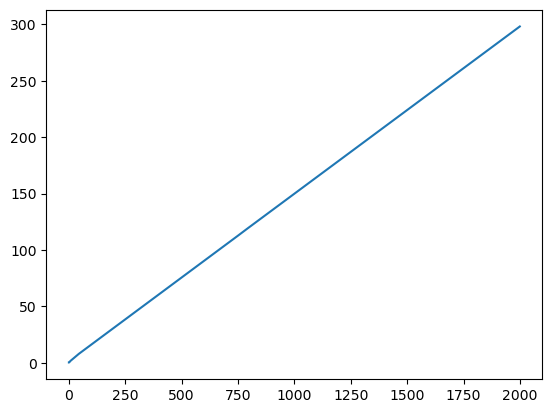

In [8]:
#build a bandit with arms 0.3,0.5,0.25,0.1
mu = np.array([0.3, 0.5, 0.25, 0.1])
B = GaussianBandit(mu)
K=len(mu)
#run FTL on the bandit
regrets = np.zeros((T,N))
for n in range(N):
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    for t in range(T):
        arm = FTL(emp_means, nb_pulls, t)
        actions[t] = arm
        rewards = B.sample(arm)
        regrets[t,n] = regret(mu, actions[:t+1])[t]
        nb_pulls[arm] += 1
        emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
print(actions[:20])
mean_regret = np.mean(regrets, axis=1)
plt.plot(mean_regret)
plt.show()





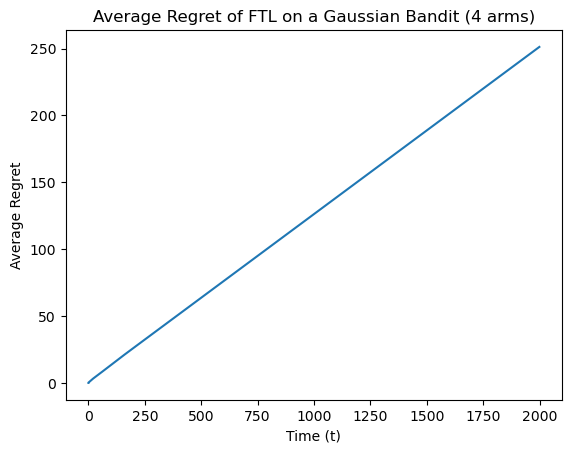

In [9]:
import matplotlib.pyplot as plt

def run_FTL_experiment(bandit, T, num_experiments):
    total_regrets = np.zeros(T)

    for _ in range(num_experiments):
        # Reset the bandit for a new experiment
        bandit_instance = bandit()
        emp_means = np.zeros(len(bandit_instance.means))
        nb_pulls = np.zeros(len(bandit_instance.means))
        regrets = np.zeros(T)
        
        for t in range(T):
            # Select arm using FTL
            arm = FTL(emp_means, nb_pulls, t)
            reward = bandit_instance.sample(arm)
            nb_pulls[arm] += 1
            emp_means[arm] += (reward - emp_means[arm]) / nb_pulls[arm]
            
            # Update regret
            optimal_reward = max(bandit_instance.means)
            regrets[t] = optimal_reward - bandit_instance.means[arm]

        total_regrets += np.cumsum(regrets)

    # Average over all experiments
    average_regrets = total_regrets / num_experiments
    return average_regrets


# Define GaussianBandit with specified means
means = [0.3, 0.5, 0.25, 0.1]
GaussianBandit4 = lambda: GaussianBandit(means)


# Run experiment and plot
average_regrets = run_FTL_experiment(GaussianBandit4, T, N)
plt.plot(range(T), average_regrets)
plt.xlabel("Time (t)")
plt.ylabel("Average Regret")
plt.title("Average Regret of FTL on a Gaussian Bandit (4 arms)")
plt.show()

**Look at several individual runs of FTL (in particular look at the sequence of actions). How can we explain the bad expected regret of FTL?**

For every try we did, the curve tend towards a linear curve with a slope between 0.2 and 0.4. This is due to the fact that the algorithm will always pull the arm with the highest empirical mean after some time. However, the arm with the highest empirical mean is not necessarily the arm with the highest mean. This is why the regret is not 0.

On the two examples we displayed, the algorithm find the arm number 1 to be the best and then the arm 0.

# $\varepsilon$-greedy

In order to obtain sub-linear regret, an algorithm should balance *exploration* and *exploitation*. The $\varepsilon$-greedy algorithm selects with probability $\varepsilon$ an arm uniformly at random (exploration) and with probability $1 - \varepsilon$ it chooses the empirical best arm like FTL.

**Implement $\varepsilon$-greedy for a decreasing $\varepsilon_t = c/t$, where $c$ is a parameter and $t$ is the current time.**

In [10]:
def eps_greedy(emp_means, nb_pulls, t,eps_0):
    """
    eps-greedy arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by eps-greedy
    """
    eps = eps_0/(t+1)
    if rng.random() < eps:
        return rng.integers(0, len(emp_means))
    else:
        if 0 in nb_pulls:
            return np.argmin(nb_pulls)
    return np.argmax(emp_means)

# UCB

The UCB algorithm is optimistic: it selects the arm with highest upper confidence bound. Using concentration of measure arguments, we can construct confidence intervals on the means of each arm, such that the true mean belongs to the interval with large enough probability. UCB then selects the arm with highest upper bound for the confidence interval.

The algorithm starts by pulling all arms: $A_t = t$ for $t \le K$. Then, using a confidence interval obtained from a 1-sub-Gaussian assumption, UCB selects

$$A_t = \arg\max_a \hat{\mu}_{t,a} + \sqrt{\frac{2 \log t}{N_{t,a}}} \: .$$



**Implement the UCB algorithm**

In [11]:
def UCB(emp_means, nb_pulls, t):
    """
    UCB arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by UCB
    """
    K = len(emp_means)

    # Check if t is less than K to pull each arm once initially
    if t < K:
        return t

    # Calculate UCB for each arm
    ucb_values = emp_means + np.sqrt((2 * np.log(t + 1)) / nb_pulls)
    
    # Select the arm with the highest UCB value
    return np.argmax(ucb_values)

**Plot the mean regret of FTL, $\varepsilon_t$-greedy and UCB on a Gaussian bandit with 4 arms with means [0.3, 0.5, 0.25, 0.1] as a function of $t$ up to $T = 2000$, averaged over 30 experiments.**

See the lecture notes for a good theoretical choice of the parameter $c$ in $\varepsilon_t$-greedy.

In [12]:
T=2000
N=30
mu = np.array([0.3, 0.5, 0.25, 0.1])
B = GaussianBandit(mu)
K=len(mu)

We try some arbitrary epsilon just to test the function.

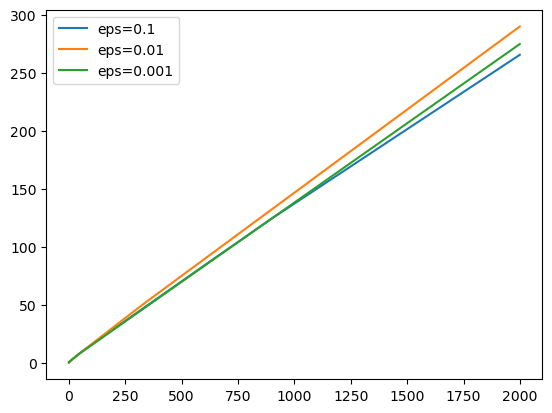

In [13]:
for eps in [0.1, 0.01, 0.001]:
    regrets = np.zeros((T,N))
    for n in range(N):
        emp_means = np.zeros(K)
        nb_pulls = np.zeros(K)
        actions = np.zeros(T, dtype=int)
        for t in range(T):
            arm = eps_greedy(emp_means, nb_pulls, t,eps)
            actions[t] = arm
            rewards = B.sample(arm)
            regrets[t,n] = regret(mu, actions[:t+1])[t]
            nb_pulls[arm] += 1
            emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
    mean_regret = np.mean(regrets, axis=1)
    plt.plot(mean_regret, label=f"eps={eps}")
plt.legend()
plt.show()


We know the means of the arms, so we can choose (from the lecture) $\epsilon_t = \frac{K}{d^2 t}$ with $d = \min_{i \neq j} |\mu_i - \mu_j|$. Here $d = 0.2$ so we can choose $\epsilon_t = \frac{100}{t}$ (i.e c = 100).

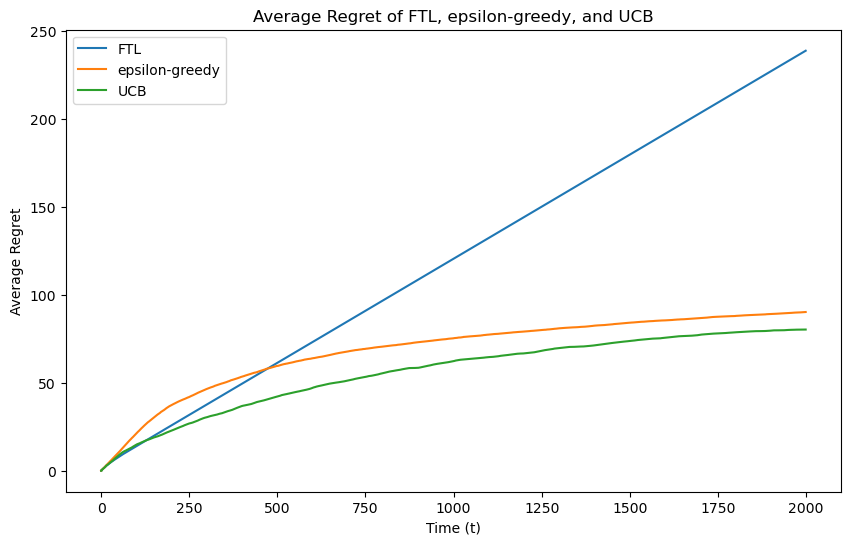

In [15]:
def run_bandit_experiment(bandit, algorithm, T, num_experiments, **kwargs):
    total_regrets = np.zeros(T)

    for _ in range(num_experiments):
        bandit_instance = bandit()
        emp_means = np.zeros(len(bandit_instance.means))
        nb_pulls = np.zeros(len(bandit_instance.means))
        regrets = np.zeros(T)

        for t in range(T):
            arm = algorithm(emp_means, nb_pulls, t, **kwargs)
            reward = bandit_instance.sample(arm)
            nb_pulls[arm] += 1
            emp_means[arm] += (reward - emp_means[arm]) / nb_pulls[arm]

            # Update regret
            optimal_reward = max(bandit_instance.means)
            regrets[t] = optimal_reward - bandit_instance.means[arm]

        total_regrets += np.cumsum(regrets)

    # Average over all experiments
    return total_regrets / num_experiments

# Bandit definition
means = [0.3, 0.5, 0.25, 0.1]
GaussianBandit4 = lambda: GaussianBandit(means)

# Parameters for the experiment
T = 2000
num_experiments = 30
c = 100  # Theoretical choice of c for epsilon-greedy

# Run experiments for each algorithm
regret_FTL = run_bandit_experiment(GaussianBandit4, FTL, T, num_experiments)
regret_eps_greedy = run_bandit_experiment(GaussianBandit4, eps_greedy, T, num_experiments, eps_0=c)
regret_UCB = run_bandit_experiment(GaussianBandit4, UCB, T, num_experiments)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(T), regret_FTL, label="FTL")
plt.plot(range(T), regret_eps_greedy, label="epsilon-greedy")
plt.plot(range(T), regret_UCB, label="UCB")
plt.xlabel("Time (t)")
plt.ylabel("Average Regret")
plt.title("Average Regret of FTL, epsilon-greedy, and UCB")
plt.legend()
plt.show()

**Comment on the graph. What is the dependence in $T$ of the regret of UCB?**

> First of all, FTL shows a tendency for higher regret, especially as T increases. This is due to its lack of exploration once it settles on what it initially assesses as the best arm.
>
> The ε-greedy algorithm, with a decreasing value of ε over time, offers a balance between exploration and exploitation. Its performance is generally better than FTL but not as effective as UCB in this scenario.
>
> The UCB algorithm shows a relatively lower regret compared to FTL and ε-greedy. This indicates that UCB is more effective in balancing exploration and exploitation in this bandit problem.
>
> The UCB algorithm's regret increases over time, but the rate of increase slows down. This pattern suggests that UCB's regret has a sublinear dependency on T, the time horizon. In other words, the regret grows over time, but it does not grow linearly with T. This is a desirable property in bandit problems, as it implies that the average regret per round decreases as we play more rounds, and the algorithm becomes more effective at identifying and exploiting the best arm.
>
> Theoretically, the regret of UCB is known to be logarithmic in T. More precisely, the regret of UCB can be bounded by a term that grows logarithmically with T and linearly with the number of arms. This aligns with the observed trend in the plot, where the regret grows over time but at a decreasing rate.

Consider the following variant UCB(c), which takes a parameter $c>0$,
$$A_t = \arg\max_a \hat{\mu}_{t,a} + \sqrt{\frac{c \log t}{N_{t,a}}} \: .$$

**Implement UCB(c) and plot the regret of UCB(c) for varying values of $c$, first for the Gaussian bandit, then for a Bernoulli bandit with same means. Discuss.**

In [19]:
def UCB_c(emp_means, nb_pulls, t,c):
    """
    UCB arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by UCB
    """
    K = len(emp_means)

    # Check if t is less than K to pull each arm once initially
    if t < K:
        return t

    # Calculate UCB values for each arm
    ucb_values = emp_means + np.sqrt(c * np.log(t + 1) / nb_pulls)
    
    # Select the arm with the highest UCB value
    return np.argmax(ucb_values)


In [20]:
# Define a function to plot the regret for varying values of c
def plot_regret_for_ucb_c(bandit, c_values, T, num_experiments, title):
    plt.figure(figsize=(10, 6))
    for c in c_values:
        average_regret = run_bandit_experiment(bandit, UCB_c, T, num_experiments, c=c)
        plt.plot(range(T), average_regret, label=f"UCB(c={c})")

    plt.xlabel("Time (t)")
    plt.ylabel("Average Regret")
    plt.title(title)
    plt.legend()
    plt.show()

# Bandit definitions
GaussianBandit4 = lambda: GaussianBandit([0.3, 0.5, 0.25, 0.1])
BernoulliBandit4 = lambda: BernoulliBandit([0.3, 0.5, 0.25, 0.1])

# Parameters for the experiment
T = 20000
num_experiments = 30
c_values = [0.001,0.01,0.1,0.5,1,10,100] 

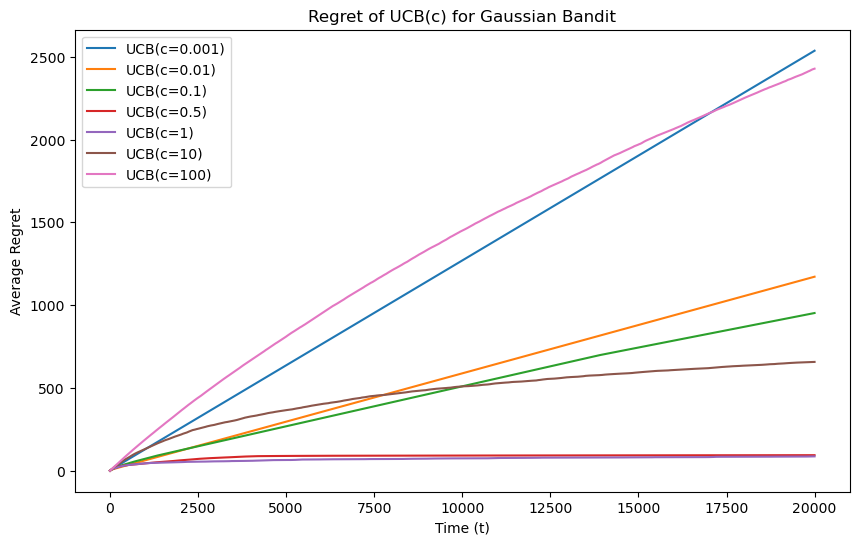

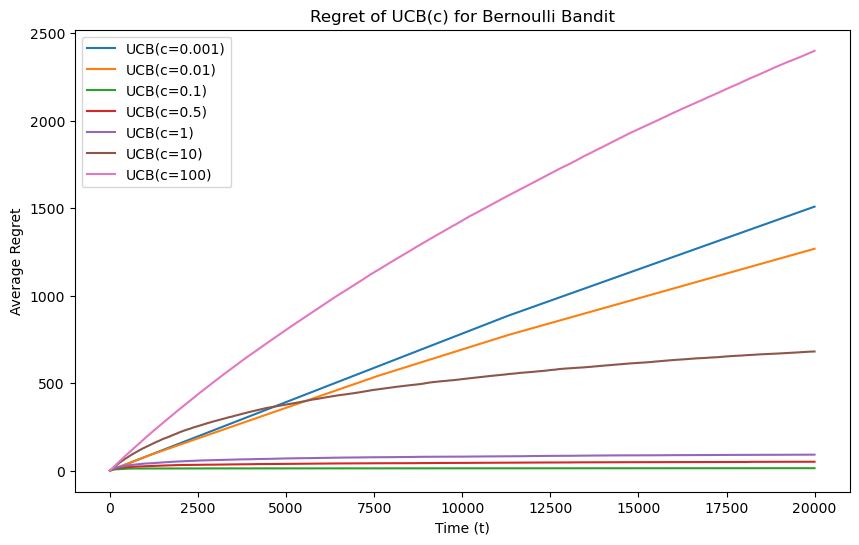

In [21]:

# Plotting for Gaussian Bandit
plot_regret_for_ucb_c(GaussianBandit4, c_values, T, num_experiments, "Regret of UCB(c) for Gaussian Bandit")

# Plotting for Bernoulli Bandit
plot_regret_for_ucb_c(BernoulliBandit4, c_values, T, num_experiments, "Regret of UCB(c) for Bernoulli Bandit")


# Thompson Sampling

The Thompson Sampling (TS) algorithm takes a Bayesian approach (even though the regret metric is a frequentist way of evaluating an algorithm).

The algorithm postulates a prior distribution for the means of the arms, say a Gaussian $\mathcal{N}(0,1)$. Then after each pull, it updates the posterior distribution of the mean of each arm.

After $N_{t,a}$ observations sampled from a Gaussian distribution with variance 1, with average reward $\hat{\mu}_{t,a}$, arm $a$ has posterior distribution $P_{a,t} = \mathcal N(\hat{\mu}_{t,a} \frac{N_{t,a}}{N_{t,a} + 1}, \frac{1}{N_{t,a} + 1})$.

At time $t$, the algorithm then samples the posterior distribution of each arm, and pulls the arm with highest sample. That is, it samples $\theta_{a,t} \sim P_{a,t}$ for all $a \in [K]$, then samples $A_t = \arg\max_a \theta_{a,t}$.

**Implement Gaussian Thompson Sampling**

In [22]:
def TS(emp_means, nb_pulls, t):
    """
    TS arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by TS
    """
    
    K = len(emp_means)
    pulls=np.zeros(K)
    for k in range(K):
        if nb_pulls[k]==0:
            pulls[k]=np.random.normal(0,1)
        else:
            pulls[k]=np.random.normal(emp_means[k]*(nb_pulls[k])/(nb_pulls[k]+1),1/(nb_pulls[k]+1))
    return np.argmax(pulls)
        
    

**Plot the regret of Gaussian TS and UCB on the Gaussian bandit from previous questions, as well as on a Bernoulli bandit with same means. Discuss.**

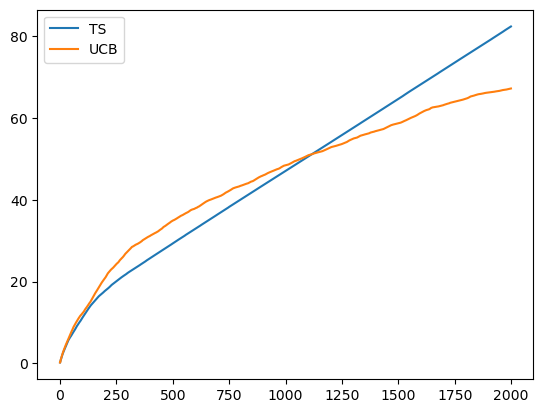

In [23]:
T=2000
N=30
mu = np.array([0.3, 0.5, 0.25, 0.1])
B = GaussianBandit(mu)
K=len(mu)

regrets = np.zeros((T,N))
for n in range(N):
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    for t in range(T):
        arm = TS(emp_means, nb_pulls, t)
        actions[t] = arm
        rewards = B.sample(arm)
        regrets[t,n] = regret(mu, actions[:t+1])[t]
        nb_pulls[arm] += 1
        emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
mean_regret = np.mean(regrets, axis=1)
plt.plot(mean_regret)

regrets = np.zeros((T,N))
for n in range(N):
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    for t in range(T):
        arm = UCB(emp_means, nb_pulls, t,1)
        actions[t] = arm
        rewards = B.sample(arm)
        regrets[t,n] = regret(mu, actions[:t+1])[t]
        nb_pulls[arm] += 1
        emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
mean_regret = np.mean(regrets, axis=1)
plt.plot(mean_regret)

plt.legend(["TS","UCB"])

plt.show()

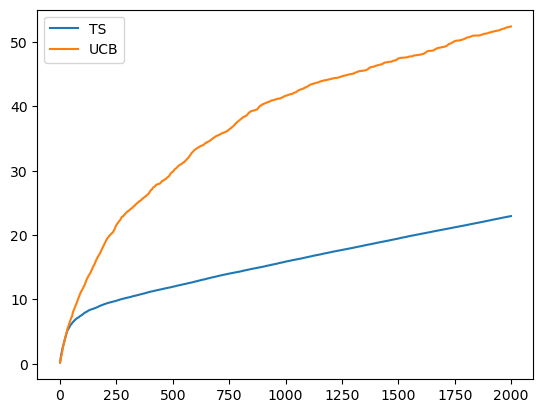

In [24]:
T=2000
N=30
mu = np.array([0.3, 0.5, 0.25, 0.1])
B = BernoulliBandit(mu)
K=len(mu)

regrets = np.zeros((T,N))
for n in range(N):
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    for t in range(T):
        arm = TS(emp_means, nb_pulls, t)
        actions[t] = arm
        rewards = B.sample(arm)
        regrets[t,n] = regret(mu, actions[:t+1])[t]
        nb_pulls[arm] += 1
        emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
mean_regret = np.mean(regrets, axis=1)
plt.plot(mean_regret)

regrets = np.zeros((T,N))
for n in range(N):
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    for t in range(T):
        arm = UCB(emp_means, nb_pulls, t,1)
        actions[t] = arm
        rewards = B.sample(arm)
        regrets[t,n] = regret(mu, actions[:t+1])[t]
        nb_pulls[arm] += 1
        emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
mean_regret = np.mean(regrets, axis=1)
plt.plot(mean_regret)

plt.legend(["TS","UCB"])

plt.show()

Thompson sampling can be adapted to the reward distributions by changing the prior: if the rewards are Gaussian, a Gaussian prior makes sense and leads to a Gaussian posterior. If the rewards are Bernoulli, we can use a uniform prior, which leads to a Beta posterior (see lecture 6 for the precise parameters of the Beta posterior).

**Implement TS with uniform prior and Beta posterior**

In [25]:
def TS_beta(emp_means, nb_pulls, t,type_bandit):
    """
    TS arm selection

    emp_means: numpy.ndarray; vector of empirical means of the arms
    nb_pulls: numpy.ndarray; number of times each arm was chosen previously
    t: int; current time
    
    Returns: int; arm selected by TS
    """
    pulls=np.zeros(len(emp_means))
    for k in range(len(emp_means)):
        if nb_pulls[k]==0:
            #choose uniformly an arm at random
            pulls[k]=np.random.choice(len(emp_means))
        else:
            if type_bandit=="Bernouilli":
                pulls[k]=np.random.beta(emp_means[k]*(nb_pulls[k])+1,1+nb_pulls[k]-emp_means[k]*(nb_pulls[k]))
            elif type_bandit=="Gaussian":
                alpha_posterior =max(1e-6, 1 + emp_means[k] * nb_pulls[k])
                beta_posterior = max(1e-6,1 + (1 - emp_means[k]) * nb_pulls[k])
            
            # Sample from the posterior Beta distribution
                pulls[k] = np.random.beta(alpha_posterior, beta_posterior)
    return np.argmax(pulls)

**On a Gaussian bandit, compare the regret of TS with Gaussian prior, TS with Bernoulli prior, and UCB.**

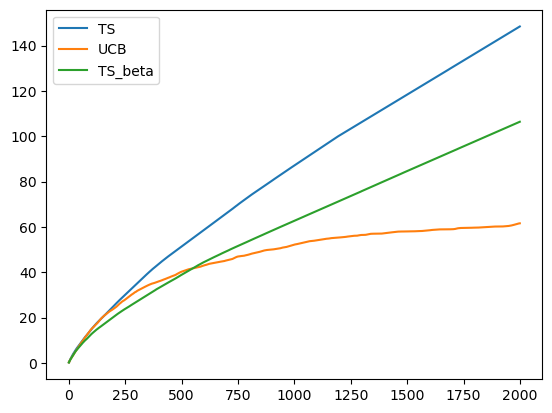

In [26]:
T=2000
N=30
mu = np.array([0.3, 0.5, 0.25, 0.1])
B = GaussianBandit(mu)
K=len(mu)

regrets = np.zeros((T,N))
for n in range(N):
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    for t in range(T):
        arm = TS(emp_means, nb_pulls, t)
        actions[t] = arm
        rewards = B.sample(arm)
        regrets[t,n] = regret(mu, actions[:t+1])[t]
        nb_pulls[arm] += 1
        emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
mean_regret = np.mean(regrets, axis=1)
plt.plot(mean_regret)

regrets = np.zeros((T,N))
for n in range(N):
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    for t in range(T):
        arm = UCB(emp_means, nb_pulls, t,1)
        actions[t] = arm
        rewards = B.sample(arm)
        regrets[t,n] = regret(mu, actions[:t+1])[t]
        nb_pulls[arm] += 1
        emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
mean_regret = np.mean(regrets, axis=1)
plt.plot(mean_regret)

regrets = np.zeros((T,N))
for n in range(N):
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    eps_0=100
    for t in range(T):
        arm = TS_beta(emp_means, nb_pulls, t,"Gaussian")
        actions[t] = arm
        rewards = B.sample(arm)
        regrets[t,n] = regret(mu, actions[:t+1])[t]
        nb_pulls[arm] += 1
        emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
mean_regret = np.mean(regrets, axis=1)
plt.plot(mean_regret)

plt.legend(["TS","UCB","TS_beta"])

plt.show()

**On a Bernoulli bandit, compare the regret of TS with Gaussian prior, TS with Bernoulli prior, and UCB.**

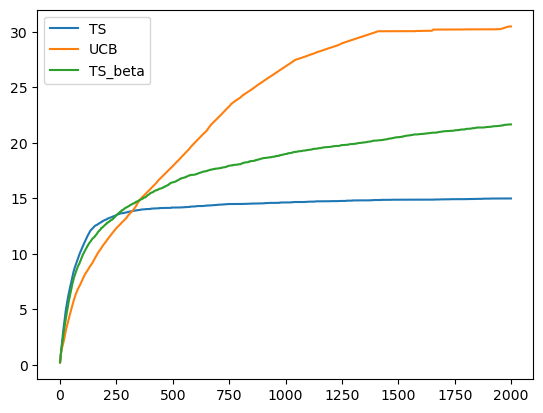

In [27]:
T=2000
N=30
mu = np.array([0.3, 0.5, 0.25, 0.1])
B = BernoulliBandit(mu)
K=len(mu)

regrets = np.zeros((T,N))
for n in range(N):
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    for t in range(T):
        arm = TS(emp_means, nb_pulls, t)
        actions[t] = arm
        rewards = B.sample(arm)
        regrets[t,n] = regret(mu, actions[:t+1])[t]
        nb_pulls[arm] += 1
        emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
mean_regret = np.mean(regrets, axis=1)
plt.plot(mean_regret)

regrets = np.zeros((T,N))
for n in range(N):
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    for t in range(T):
        arm = UCB(emp_means, nb_pulls, t,0.1)
        actions[t] = arm
        rewards = B.sample(arm)
        regrets[t,n] = regret(mu, actions[:t+1])[t]
        nb_pulls[arm] += 1
        emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
mean_regret = np.mean(regrets, axis=1)
plt.plot(mean_regret)

regrets = np.zeros((T,N))
for n in range(N):
    emp_means = np.zeros(K)
    nb_pulls = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    eps_0=100
    for t in range(T):
        arm = TS_beta(emp_means, nb_pulls, t,"Bernouilli")
        actions[t] = arm
        rewards = B.sample(arm)
        regrets[t,n] = regret(mu, actions[:t+1])[t]
        nb_pulls[arm] += 1
        emp_means[arm] = (emp_means[arm]*(nb_pulls[arm]-1) + rewards)/nb_pulls[arm]
mean_regret = np.mean(regrets, axis=1)
plt.plot(mean_regret)

plt.legend(["TS","UCB","TS_beta"])

plt.show()

**How could the UCB algorithm be improved to have a lower regret on Bernoulli bandits, if we know beforehand that the distributions are Bernoulli?**

#TODO